In [1]:
from experiments.mnli_utils import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
task_tokenizer, task_model = create_tokenizer_and_model(
    "/export/home/Experiments/20200706/")

imitator_tokenizer, imitator_model = create_tokenizer_and_model(
    "/export/home/Experiments/20200718/output_dir/")

train_dataset, eval_dataset = create_datasets(tokenizer=task_tokenizer)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [3]:
task_model.training, imitator_model.training

(False, False)

In [4]:
imitator_model.cuda()
task_model.device, imitator_model.device

(device(type='cpu'), device(type='cuda', index=0))

In [5]:
from transformers import glue_output_modes, TrainingArguments, glue_compute_metrics

output_mode = glue_output_modes["mnli"]
def build_compute_metrics_fn(task_name: str):
    def compute_metrics_fn(p):
        if output_mode == "classification":
            preds = np.argmax(p.predictions, axis=1)
        elif output_mode == "regression":
            preds = np.squeeze(p.predictions)
        return glue_compute_metrics(task_name, preds, p.label_ids)

    return compute_metrics_fn


trainer = Trainer(
    model=task_model,
    args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=build_compute_metrics_fn("mnli"),
)

train_batch_data_loader = get_dataloader(
    train_dataset,
    batch_size=160,
    data_collator=default_data_collator)

train_instance_data_loader = get_dataloader(
    train_dataset,
    batch_size=1,
    data_collator=default_data_collator)

eval_instance_data_loader = get_dataloader(
    eval_dataset,
    batch_size=1,
    data_collator=default_data_collator)

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


In [6]:
for i, test_inputs in enumerate(eval_instance_data_loader):
    logits, labels, step_eval_loss = predict(
        trainer=trainer, model=task_model, inputs=test_inputs)
    if i >= 40 and labels[0] != logits.argmax(axis=1)[0]:
        break

In [7]:
i

41

In [8]:
decode_one_example(tokenizer=task_tokenizer, label_list=train_dataset.label_list, inputs=test_inputs, logits=torch.tensor(logits))

("[CLS] What's truly striking, though, is that Jobs has never really let this idea go. [SEP] Jobs never held onto an idea for long. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 'contradiction',
 'entailment')

In [9]:
from copy import deepcopy
imitator_test_inputs = deepcopy(test_inputs)
imitator_test_inputs["labels"] = torch.tensor(logits.argmax(axis=1))
test_inputs, imitator_test_inputs

({'labels': tensor([0], device='cuda:0'),
  'input_ids': tensor([[  101,  1327,   112,   188,  5098,  8261,   117,  1463,   117,  1110,
            1115, 18235,  1116,  1144,  1309,  1541,  1519,  1142,  1911,  1301,
             119,   102, 18235,  1116,  1309,  1316,  2135,  1126,  1911,  1111,
            1263,   119,   102,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,  

In [10]:
influences = torch.load("/export/home/Experiments/20200706/influences.tmp.pt.full")
train_inputs_collections = torch.load("/export/home/Experiments/20200706/train_inputs_collections.tmp.pt.full")

In [11]:
entailment_examples = [i for i in range(len(train_inputs_collections))
                       if train_dataset.label_list[train_inputs_collections[i]["labels"]] == "entailment"]

contradiction_examples = [i for i in range(len(train_inputs_collections))
                       if train_dataset.label_list[train_inputs_collections[i]["labels"]] == "contradiction"]

neutral_examples = [i for i in range(len(train_inputs_collections))
                       if train_dataset.label_list[train_inputs_collections[i]["labels"]] == "neutral"]

In [12]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from influence_utils.influence import compute_gradients
from collections import defaultdict


params_to_freeze = [
    "bert.embeddings.",
    "bert.encoder.layer.0.",
    "bert.encoder.layer.1.",
    "bert.encoder.layer.2.",
    "bert.encoder.layer.3.",
    "bert.encoder.layer.4.",
    "bert.encoder.layer.5.",
    "bert.encoder.layer.6.",
    "bert.encoder.layer.7.",
    "bert.encoder.layer.8.",
    "bert.encoder.layer.9.",
] + [
    "bert.pooler.dense.weight",
    "bert.pooler.dense.bias"]

params_filter = None
weight_decay_ignores = None
weight_decay = 0.005
weight_decay_ignores = None
if params_filter is None:
    params_filter = [
        "bert.pooler.dense.weight",
        "bert.pooler.dense.bias"] + [
        n for n, p in imitator_model.named_parameters()
        if not p.requires_grad]

# We actually included `bert.pooler.dense.*`
# but this should be fine? Because the gradients
# of these parameters are not included anyway.
if weight_decay_ignores is None:
    weight_decay_ignores = [
        "bias",
        "LayerNorm.weight"] + [
        n for n, p in imitator_model.named_parameters()
        if not p.requires_grad]
    

learning_rates = np.logspace(-5, -2.5, 50)
def prepare_plot_data(indices, labels):
    losses = defaultdict(list)
    for index, label in zip(tqdm(indices), labels):
        helpful_grad_z = compute_gradients(
            n_gpu=1,
            device=torch.device("cuda"),
            model=imitator_model,
            inputs=train_inputs_collections[index],
            params_filter=params_filter,
            weight_decay=weight_decay,
            weight_decay_ignores=weight_decay_ignores)

        step_eval_losses = []
        for lr in learning_rates:
            new_imitator_model = deepcopy(imitator_model)
            params_to_update = [p for name, p in new_imitator_model.named_parameters()
                                if not any(pfreeze in name for pfreeze in params_to_freeze)]
            with torch.no_grad():
                [p.sub_(lr * grad_z) for p, grad_z in zip(params_to_update, helpful_grad_z)]

            _, _, imitator_step_eval_loss = predict(
                trainer=trainer,
                model=new_imitator_model,
                inputs=imitator_test_inputs)
            step_eval_losses.append(imitator_step_eval_loss)
        losses[label].append(step_eval_losses)

    return losses

In [13]:
data_indices = (
    np.argsort(influences)[:100].tolist() +
    np.argsort(influences)[-100:].tolist() +
    [np.random.choice(contradiction_examples) for _ in range(100)] +
    [np.random.choice(entailment_examples) for _ in range(100)] +
    [np.random.choice(neutral_examples) for _ in range(100)]
)

data_labels = (
    ["least-influential" for _ in range(100)] +
    ["most-influential" for _ in range(100)] +
    ["random-contradiction" for _ in range(100)] +
    ["random-entailment" for _ in range(100)] +
    ["random-neutral" for _ in range(100)]
)

losses = prepare_plot_data(indices=data_indices, labels=data_labels)

100%|██████████| 500/500 [12:45<00:00,  1.53s/it]


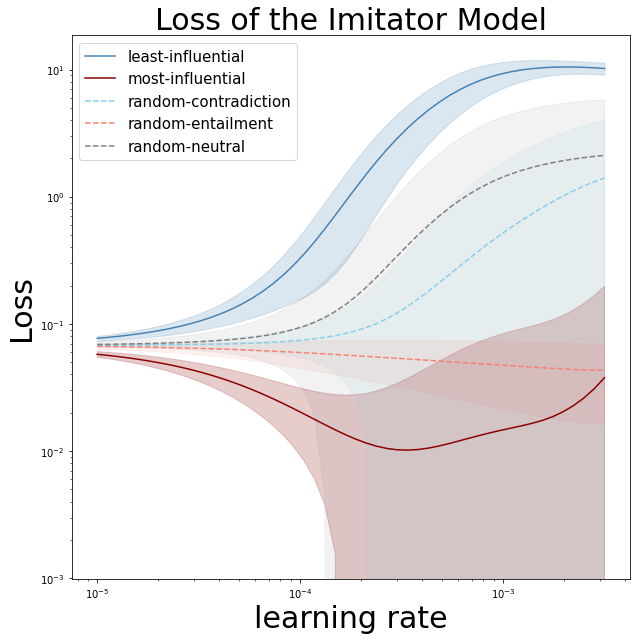

In [17]:
plt.rcParams["figure.figsize"] = (10, 10)
legends = []
for label in losses.keys():
    c = {
        "most-influential": "darkred",
        "least-influential": "steelblue",
        "random-neutral": "grey",
        "random-entailment": "salmon",
        "random-contradiction": "skyblue"
    }[label]
    data_for_visualization = np.array(losses[label])
    if data_for_visualization.shape[0] != 1:
        data_mean = data_for_visualization.mean(axis=0)
        data_max = data_for_visualization.max(axis=0)
        data_min = data_for_visualization.min(axis=0)
        data_std = data_for_visualization.std(axis=0)
        plt.plot(
            learning_rates,
            data_mean,
            color=c,
            linestyle=(
                "--" if "random" in label else None))
        plt.fill_between(
            learning_rates,
            data_mean + 1. * data_std,
            data_mean - 1. * data_std,
            alpha=(
                0.1 if "random" in label else 0.2),
            color=c)
#         plt.fill_between(
#             learning_rates,
#             data_max,
#             data_min, alpha=0.1, color=c)
        legends.append(label)
    else:
        plt.plot(
            learning_rates,
            data_for_visualization[0, ...],
            color=c)
        legends.append(label)

plt.legend(legends, fontsize=15)
plt.xlabel("learning rate", fontsize=30)
plt.ylabel("Loss", fontsize=30)
plt.title("Loss of the Imitator Model", fontsize=30)
plt.xscale("log")
plt.yscale("log")
plt.savefig("./20200719-fig1.pdf")